# CIFAR-100 και Tranfer Learning

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals # legacy compatibility

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## To CIFAR-100

![](https://datarepository.wolframcloud.com/resources/images/69f/69f1e629-81e6-4eaa-998f-f6734fcd2cb3-io-4-o.en.gif)

Τα [CIFAR-10 και CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) είναι μαζί με το MNIST τα διασημότερα dataset στην όραση υπολογιστών

Αποτελούν υποσύνολα του συνόλου δεδομένων 80 million tiny images. Συλλέχθηκαν από τους Alex Krizhevsky (του AlexNet), Vinod Nair και Geoffrey Hinton.

Το CIFAR-10 έχει 10 κατηγορίες εικόνων και το CIFAR-100 100.

CIFAR σημαίνει Canadian Institute for Advanced Research.

Το 2004, ο Geoffrey Hinton άρχισε να ηγείται του προγράμματος Νευρωνικός Υπολογισμός και Προσαρμοστική Αντίληψη του CIFAR. Στα μέλη του περιλαμβάνονται οι Yoshua Bengio και Yann LeCun, μεταξύ άλλων νευροεπιστημόνων, επιστημόνων υπολογιστών, βιολόγων, ηλεκτρολόγων μηχανικών, φυσικών και ψυχολόγων. 

Σήμερα, οι τρεις τους αναγνωρίζονται ευρέως ως οι πρωτοπόροι της βαθιάς μάθησης. 

Το 2019, η Association for Computing Machinery (ACM), ονόμασε τους Hinton, Bengio και LeCun ως αποδέκτες του βραβείου ACM A.M. Turing Award 2018 για τις εννοιολογικές και μηχανικές ανακαλύψεις που έκαναν τα βαθιά νευρωνικά δίκτυα ένα κρίσιμο συστατικό της πληροφορικής.

Oυσιαστικά, το Turing Award απονεμήθηκε στο CIFAR, το οποίο μετράει επίσης 20 νομπελίστες στις τάξεις του. 


To CIFAR-100 δεν είναι εύκολο dataset. Έχει πολλές κατηγορίες, κάποιες πολύ κοντινές, και η ανάλυση είναι χαμηλή, 32x32 pixels.

## Εισαγωγή και επισκόπηση του συνόλου δεδομένων

In [2]:
# load the entire dataset
(x_train_ds, y_train_ds), (x_test_ds, y_test_ds) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

169017344/169001437 [==============================] - 2s 0us/step


In [3]:
print(x_train_ds.shape)

(50000, 32, 32, 3)


In [4]:
# διαβάζουμρ τα ονόματα των κλάσεων από ένα text file που τα έχουμε αποθηκεύσει 

CIFAR100_LABELS_LIST = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

In [5]:
# print our classes
print(CIFAR100_LABELS_LIST)

['apple', ' aquarium_fish', ' baby', ' bear', ' beaver', ' bed', ' bee', ' beetle', ' bicycle', ' bottle', ' bowl', ' boy', ' bridge', ' bus', ' butterfly', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' chimpanzee', ' clock', ' cloud', ' cockroach', ' couch', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' house', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' oak_tree', ' orange', ' orchid', ' otter', ' palm_tree', ' pear', ' pickup_truck', ' pine_tree', ' plain', ' plate', ' poppy', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' shrew', ' skunk', ' skyscraper', ' snail', ' snake', ' spider', ' squirrel', ' streetcar', ' sunflower', ' sweet_pepper', ' table', ' tank', ' telephone', ' television', ' tig

7500
Train: X=(42500, 32, 32, 3), y=(42500, 1)
Validation: X=(7500, 32, 32, 3), y=(7500, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


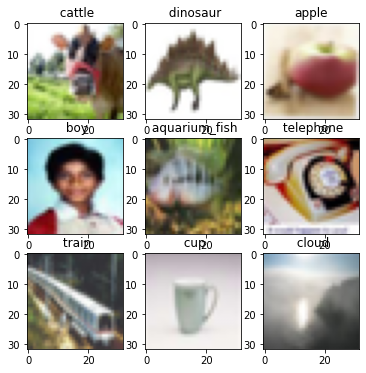

In [6]:
# get (train) dataset dimensions
data_size, img_rows, img_cols, img_channels = x_train_ds.shape

# set validation set percentage (wrt the training set size)
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

print(len(x_val))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation: X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# get class label from class index
def class_label_from_index(fine_category):
  return(CIFAR100_LABELS_LIST[fine_category.item(0)])

# plot first few images
plt.figure(figsize=(6, 6))
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i).set_title(class_label_from_index(y_train[i]))
	# plot raw pixel data
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  #show the figure
plt.show()

## Συναρτήσεις εκπαίδευσης

Θα χρησιμοποιήσουμε την ιδιότητα prefetch του TF2 για καλύτερες επιδόσεις στην εκπαίδευση: 

In [7]:
# we user prefetch https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch 
# see also AUTOTUNE
# the dataset is now "infinite"

BATCH_SIZE = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE # https://www.tensorflow.org/guide/data_performance

def _input_fn(x,y, BATCH_SIZE):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds =_input_fn(x_train,y_train, BATCH_SIZE) #PrefetchDataset object
validation_ds =_input_fn(x_val,y_val, BATCH_SIZE) #PrefetchDataset object
test_ds =_input_fn(x_test,y_test, BATCH_SIZE) #PrefetchDataset object

# steps_per_epoch and validation_steps for training and validation: https://www.tensorflow.org/guide/keras/train_and_evaluate

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_ds, validation_steps=validation_steps)
  return(history)

## Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	plt.figure(figsize=(8, 8))
	plt.suptitle('Training Curves')
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.legend(loc='upper right')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.legend(loc='lower right')
	return plt
 
# print test set evaluation metrics
def model_evaluation(model, evaluation_steps):
	print('\nTest set evaluation metrics')
	loss0,accuracy0 = model.evaluate(test_ds, steps = evaluation_steps)
	print("loss: {:.2f}".format(loss0))
	print("accuracy: {:.2f}".format(accuracy0))

def model_report(model, history, evaluation_steps = 10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)

## Μοντέλα δικτύων

### Ένα μικρό συνελικτικό δίκτυο "from scratch"

In [9]:
# a simple CNN https://www.tensorflow.org/tutorials/images/cnn

def init_simple_model(summary):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [10]:
SIMPLE_MODEL = init_simple_model(summary = True)
SIMPLE_MODEL_history = train_model(SIMPLE_MODEL, 50, 30, 5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

### Μεταφορά μάθησης: VGG16
Θα χρησιμοποιήσουμε ένα [VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16) προεκπαιδευμένο στο ImageNet, χωρίς το classification head.

In [11]:
# transfer learning: VGG16 trained on ImageNet without the top layer

def init_VGG16_model(summary):
  vgg_model=tf.keras.applications.VGG16(input_shape=(32,32,3), include_top=False, weights='imagenet')
  
  VGG16_MODEL=vgg_model.layers[0](vgg_model)

  # unfreeze conv layers
  VGG16_MODEL.trainable=True
  
  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [12]:
VGG16_MODEL = init_VGG16_model(True)
VGG16_MODEL_history = train_model(VGG16_MODEL, 50, 30, 5)

#model_report(VGG16_MODEL, VGG16_MODEL_history, 30)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 100)               51300     
                                                                 
Total params: 14,765,988
Trainable params: 14,765,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
30/30 [=========================

### Μεταφορά μάθησης: ResNet152V2
Θα χρησιμοποιήσουμε ένα [ResNet152V2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet152V2) προεκπαιδευμένο στο ImageNet, χωρίς το classification head.

In [13]:
# transfer learning: ResNet152V2 trained on ImageNet without the top layer


def init_ResNet152V2_model(summary):
  ResNet152V2_model=tf.keras.applications.ResNet152V2(input_shape=(32,32,3), include_top=False, weights='imagenet')
  
  ResNet152V2_MODEL=ResNet152V2_model.layers[0](ResNet152V2_model)

  # unfreeze conv layers
  ResNet152V2_MODEL.trainable=True
  
#  dropout_layer = tf.keras.layers.Dropout(rate = 0.5)
#  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # add top layer for CIFAR100 classification
  prediction_layer = tf.keras.layers.Dense(len(CIFAR100_LABELS_LIST),activation='softmax')
  model = tf.keras.Sequential([ResNet152V2_MODEL, prediction_layer])
  #model = tf.keras.Sequential([ResNet152V2_MODEL, dropout_layer, global_average_layer, prediction_layer])
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

In [14]:
ResNet152V2_MODEL = init_ResNet152V2_model(True)
ResNet152V2_MODEL_history = train_model(ResNet152V2_MODEL,  50, 30, 5)

234561536/234545216 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 1, 1, 2048)        58331648  
                                                                 
 dense_3 (Dense)             (None, 1, 1, 100)         204900    
                                                                 
Total params: 58,536,548
Trainable params: 58,392,804
Non-trainable params: 143,744
_________________________________________________________________
Epoch 1/50
30/30 [==============================] - 37s 485ms/step - loss: 5.2142 - accuracy: 0.0101 - val_loss: 4.6211 - val_accuracy: 0.0096
Epoch 2/50
30/30 [==============================] - 11s 375ms/step - loss: 4.7760 - accuracy: 0.0100 - val_loss: 4.6129 - val_accuracy: 0.0103
Epoch 3/50
30/30 [==============================] - 11s 376ms/step - loss: 4.66

# Βελτίωση της επίδοσης με πειράματα

Από τα τρια προηγούμενα νευρωνικά, με τον μικρό αριθμό εποχών που θέσαμε, μοιάζει ότι δεν ισχύει το "bigger is better" καθώς το VGG16 φαίνεται να είναι το καταλληλότερο για το task.

- Μπορείτε να δώσετε κάποιες ερμηνείες για την επίδοση των τριών μοντέλων;

- Μπορείτε να βρείτε μέθοδο (μοντέλο και εκπαιδευτική διαδικασία) για την βελτίωση των επιδόσεων στο CIFAR-100;

Α word of wisdom για το θέμα αυτό είναι: το κατάλληλο μοντέλο εξαρτάται από τρία πράγματα: *πόσο χρόνο έχουμε, τί υπολογιστικούς πόρους διαθέτουμε, ποιες επιδόσεις θεωρούμε καλές.*

Στη συνέχεια εξετάζουμε κάποιες από τις δυνατότητες που έχουμε για να βελτιώσουμε τις επιδόσεις των νευρωνικών μας με πειράματα.

## Δοκιμές διαφορετικών μοντέλων

Μπορείτε είτε να δοκιμάσετε μοντέλα "from scratch", όπου ορίζετε την αρχιτεκτονική του δικτύου όπως θέλετε, είτε να χρησιμοποιήσετε μεταφορά μάθησης.



### Μοντέλα "from scratch"

Μπορείτε να τροποποιήσετε/αλλάξετε το αρχικό μικρό συνελικτικό δίκτυο του παραδείγματος. Μπορείτε να συμβουλευτείτε 
- τη [βιβλιογραφία απο το leaderboard του CIFAR-100](https://benchmarks.ai/cifar-100) για αρχιτεκτονικές και παραμέτρους των δικτύων
- ή/και να πάρετε ιδέες [από σχετική αναζήτηση στο Google Scholar](https://scholar.google.gr/scholar?hl=en&as_sdt=0%2C5&q=cifar+100+cnn&oq=cifa)

### Μεταφορά μάθησης

Εναλλακτικά, μπορείτε να χρησιμοποιήσετ τη [μεταφορά μάθησης του tf2](https://www.tensorflow.org/tutorials/images/transfer_learning). Σε αντίθεση με τα μοντέλα "from scratch" η μεταφορά μάθησης μας επιστρέφει έτοιμα μοντέλα με προκαθορισμένη αρχιτεκτονική στην οποία μπορούμε γενικά μόνο να προσθέσουμε επίπεδα, τα οποία συνήθως περιορίζοντα σε πλήρως διασυνδεδεμένα επίπεδα που εξειδικεύονται στο συγκεκριμένο task ταξινόμησης που έχουμε να επιτελέσουμε. 

#### Εκπαίδευση βαρών

Ταυτόχρονα με την αρχιτεκτονική, στη μεταφορά μάθησης εισάγουμε και τη γνώση που έχει αποκτήσει το μοντέλο, δηλαδή τις τιμές των βαρών του όπως έχουν προκύψει μετά από εκπαίδευση συνήθως στο (τεράστιο) ImageNet. Οταν εισάγουμε ένα μοντέλο με μεταφορά μάθησης έχουμε τρεις επιλογές για την εκπαίδευση:
- να παγώσουμε τη συνελικτική βάση και να εκπαιδεύσουμε την κεφαλή ταξινόμησης (classification head). Αυτό αντιστοιχεί στο να χρησιμοποιήσουμε τη συνελικτική βάση για εξαγωγή χαρακτηριστικών (feature extraction), σημαία trainable = False.
- να συνεχίσουμε να εκπαιδεύουμε όλα τα επίπεδα του δικτύου, σημαία trainable = True.
- να εκπαιδευτεί μόνο ένα ποσοστό των επιπέδων, εβρισκόμενο προς την έξοδο του δικτύου. Οι σημαίες trainable εδώ θα πρέπει να οριστούν ανά επίπεδο.



#### Διαθέσιμα μοντέλα για μεταφορά μάθησης στο tf2

1. tf.keras.applications. Ο πιο απλός τρόπος για να κάνουμε μεταφορά μάθησης στο tf2 είναι μέσω του [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications) που παρέχει προεκπαιδευμένα μοντέλα από το Keras και συγκεκριμένα τα δίκτυα: DenseNet, Inception-ResNet V2, Inception V3, MobileNet v1, MobileNet v2, NASNet-A, ResNet, ResNet v2, VGG16, VGG19 και Xception V1. Η εισαγωγή των μοντέλων γίνεται παρόμοια με αυτή που δείξαμε παραπάνω για το VGG16.

2. TensorFlow Hub. Μπορείτε επίσης να χρησιμοποιήσετε μοντέλα τα οποία είναι διαθέσιμα στο αποθετήριο [TensoFlow Hub](https://tfhub.dev/s?fine-tunable=yes&module-type=image-augmentation,image-classification,image-feature-vector,image-generator,image-object-detection,image-others,image-style-transfer,image-rnn-agent&tf-version=tf2) το οποίο περιλαμβάνει πάνω από 100 προεκπαιδευμένα μοντέλα.

3. Αποθηκευμένα μοντέλα απο τρίτες πηγές. Μπορείτε επίσης να κάνετε μεταφορά μάθησης από τρίτες πηγές, είτε του συνόλου του νευρωνικού, αρχιτεκτονικής και βαρών, είτε μόνο της αρχιτεκτονικής ή των βαρών. Το μοντέλο θα πρέπει να έχει αποθηκευθεί σε ένα από τα δύο φορμάτ, Keras HDF5 format (.h5 ή .keras) ή στο SavedModel format που αναφέραμε στην εισαγωγή. Τα βάρη μπορούν να εισαχθούν και μόνα τους ως Checkpoints. Για περισσότερα, διαβάστε σχετικά τα λήμματα ["Save and load models"](https://www.tensorflow.org/tutorials/keras/save_and_load), ["Save and serialize"](https://www.tensorflow.org/guide/keras/save_and_serialize), ["Using the SavedModel format"](https://www.tensorflow.org/guide/saved_model) και δείτε για παράδειγμα πως μπορούμε να κάνουμε μεταφορά μάθησης από τα state-of-the-art EfficientNets ([1](https://www.dlology.com/blog/transfer-learning-with-efficientnet/), [2](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnethttps://)).

Σημειώστε ότι πολλά μοντέλα απαιτούν μεγαλύτερες διαστάσεις στην είσοδο από αυτές του CIFAR-100 και κατά συνέπεια τα δεδομένα πρέπει να [μετασχηματιστούν](https://www.tensorflow.org/api_docs/python/tf/image/resize). Προσέξτε ωστόσο τις απαιτήσεις σε μνήμη όταν αυτοί οι μετασχηματισμοί γίνονται απευθείας σε μεταβλητές (βλ. πιο κάτω "Διαχείριση μνήμης"). 


#### Zoos and Gardens

![](https://camo.githubusercontent.com/ffc27b8ea00af45c0e71785dda0d04658e964a1f8df583634637c61123add357/68747470733a2f2f73746f726167652e676f6f676c65617069732e636f6d2f6d6f64656c5f67617264656e5f6172746966616374732f54465f4d6f64656c5f47617264656e2e706e67)

Οι διάφορες βιβλιοθήκες -όχι μόνο η TensorFlow- αποκαλούν τη συλλογή εκπαιδευμένων μοντέλων τους "Zoo" ή "Garden". Παράδειγμα το [TensorFlow Model Garden](https://github.com/tensorflow/models).

### Επαύξηση δεδομένων

Μια τεχνική που μπορεί να σας δώσει καλά αποτελέσματα είναι η επάυξηση δεδομένων (data augmentation). Η επαύξηση δεδομένων επιτρέπει να δημιουργήσουμε μεγαλύτερη ποικιλία στα δεδομένα εφαρμόζοντας τυχαίους αλλά ρεαλιστικούς μετασχηματισμούς στις εικόνες, όπως πχ η περιστροφη.

Μπορούμε να κάνουμε data augmetation με δύο τρόπους: με επίπεδα προεπεξεργασίας του Keras, ή με χρήση του tf.image. Δείτε [εδώ](https://www.tensorflow.org/tutorials/images/data_augmentation) σχετικά από το documentation του TensorFlow και [εδώ](https://stepup.ai/train_data_augmentation_keras/) ένα πρακτικό παράδειγμα στο CIFAR-10.

## Παρατηρήσεις ως προς τη βελτιστοποίηση

### Διαχείριση μνήμης (TFRecord)

Η φόρτωση δεδομένων με τον τρόπο που το κάναμε παραπάνω στο απλό παράδειγμα υλοποίησης είναι πολύ βολική αλλά δεν είναι καθόλου αποτελεσματική ως προς τη διαχείριση της μνήμης. Συγκεκριμένα, με τον τρόπο αυτό, τα δεδομένα αποθηκεύονται απευθείας σε μεταβλητές, οι οποίες όλες μαζί καταλαμβάνουν τη RAM της CPU ή της GPU, κάτι που κάνει αδύνατη τη διαχείριση μεγάλων datasets ή τον μεταχηματισμό των δεδομένων όπως όταν κάνουμε αύξηση δεδομένων (data augmentation).

Για να παρακαμφθεί αυτό το πρόβλημα, υπάρχει η δυνατότητα της σειριοποίησης των δεδομένων (serialization) και της αποθήκευσής τους σε αρχεία μεσαίου μεγέθους (κάποιων MB) τα οποία μπορούνα να αναγνωστούν γραμμικά. Το φορμάτ TFRecord είναι ένα φορμάτ που επιτρέπει την αποθήκευση σειράς δυαδικών εγγραφών. Διαβάστε τα σχετικά λήμματα [TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) και [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data). 

Σημειώστε ότι με τη μέθοδο αυτή θα πρέπει να γίνει import η `tensorflow_datasets` και να χρησιμοποιήσουμε την `tfds.load` ώστε να αποθηκευθεί το σύνολο δεδομένων σε αρχεία tfrecord στο δίσκο (δείτε [εδώ](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb) ένα παράδειγμα). Φυσικά μπορούμε να μετατρέψουμε και τα πρωτογενή δεδομένα (raw data) του dataset όπως αρχεία jpg σε φορματ tfrecord όπως [εδώ](https://towardsdatascience.com/working-with-tfrecords-and-tf-train-example-36d111b3ff4d).



### Υπερεκπαίδευση

Μπορείτε να πειραματιστείτε ως προς τον έλεγχο της υπερεκπαίδευσης (overfitting) με διάφορους τρόπους. Μεταξύ αυτών μπορούμε να αναφέρουμε τους εξής:
- Πρόωρος τερματισμός (early stopping). Μια μέθοδος που τερματίζει την εκπαίδευση αν δεν υπάρχει βελτίωση ως προς τη μετρική απόδοσης που παρακολουθούμε. [tf.keras.callbacks.EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStoppinghttps://)
- Dropout. Μια άλλη τεχνική για τη μείωση της υπερεκπαίδευσης είναι το Dropout. Είναι ένα είδος ομαλοποίησης (regularization) που επιβάλλει στα βάρη του δικτύου να παίρνουν μόνο μικρές τιμές. Εάν εφαρμόσουε dropout σε ένα επίπεδο του δικτύου, τότε ένα ποσοστό των βαρών του γίνεται τυχαία μηδενικό κατά την εκπαίδευση. [Dropout](https://www.tensorflow.org/tutorials/images/classification#dropout)
- Επαύξηση δεδομένων. Η υπερεκπαίδευση συνήθως συμβαίνει όταν έχουμε λίγα ή/και πολύ όμοια δεδομένα εκπαίδευσης. Ένας τρόπος να διορθωθεί αυτό το πρόβλημα είναι να αυξήσουμε τα δεδομένα (data augmentation). Το data augmentation δημιουργεί νέα δεδομένα εκπαίδευσης με βάση τα υπάρχοντα εφαρμόζοντας τυχαίους μετασχηματισμούς ώστε να προκύπτουν αληθοφανείς εικόνες. [Data augmentation](https://www.tensorflow.org/tutorials/images/classification#data_augmentation), [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#class_imagedatagenerator)

Βλέπε επίσης [Image classification](https://www.tensorflow.org/tutorials/images/classification).

### Χρόνος εκπαίδευσης

Το TensorFlow 2 προσφέρει νέους ή βελτιώνει διάφορους μηχανισμούς βελτιστοποίησης της εκπαίδευσης. Μεταξύ αυτών έχουμε τους εξής:
- Data prefetching (το χρησιμοποιήσαμε παραπάνω)
- Data reading parallelization 
- Map transformation parallelization
- Caching
- Reducing memory footprint

Συμβουλευτείτε για τα παραπάνω το [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

### Εργαλεία υψηλού επιπέδου

Μεταξύ των εργαλείων βελτιστοποίησης υψηλού επιπέδου (high-level) του TensorFlow μπορούμε να αναφέρουμε τα ακόλουθα:

- [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) και [What-If Tool](https://www.tensorflow.org/tensorboard/what_if_tool) Επικουρικό εργαλείο οπτικοποίησης/ανάλυσης για τον πειραματισμό στη εκπαίδευση
- [tf-explain](https://tf-explain.readthedocs.io/en/latest/) Προσφέρει μεθόδους επεξηγισιμότητας για το tf2
- [Keras Tuner](https://github.com/keras-team/keras-tuner) Βελτιστοποίηση υπερπαραμέτρων του Keras στο TensorFlow 2.0
- [AutoAugment](https://github.com/tensorflow/models/tree/master/research/autoaugment) Εκμάθηση της πολιτικης επαύξησης από τα δεδομένα

# Για τις χριστουγεννιάτικες διακοπές



## What's next for Deep Learning

Οι νονοί της Τεχνητής Νοημοσύνης και νικητές του βραβείου Turing 2018 της ACM, Geoffrey Hinton, Yann LeCun και Yoshua Bengio, μοιράστηκαν τη σκηνή στη Νέα Υόρκη το βράδυ της Κυριακής 9 Φεβρουαρίου σε μια εκδήλωση που διοργάνωσε το τριακοστό τέταρτο συνέδριο AAAI για την Τεχνητή Νοημοσύνη (AAAI 2020). 

Η τριάδα των ερευνητών έχει καταστήσει τα βαθιά νευρωνικά δίκτυα ένα κρίσιμο συστατικό της πληροφορικής, και σε μεμονωμένες ομιλίες και μια συζήτηση σε πάνελ συζήτησαν τις απόψεις τους σχετικά με τις τρέχουσες προκλήσεις που αντιμετωπίζει η βαθιά μάθηση και το πού θα πρέπει να κατευθυνθεί.

In [15]:
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/UX8OubxsY8w', width=640, height=480)

## Αντίλογος



### Η κριτική του Schmidhuber για τους LBH

(Ο Schmidhuber και ο Hochreiter [εισήγαγαν τα LSTM το 1997](https://www.bioinf.jku.at/publications/older/2604.pdf))

*Machine learning is the science of credit assignment. The machine learning community itself profits from proper credit assignment to its members. The inventor of an important method should get credit for inventing it. She may not always be the one who popularizes it. Then the popularizer should get credit for popularizing it (but not for inventing it). Relatively young research areas such as machine learning should adopt the honor code of mature fields such as mathematics: if you have a new theorem, but use a proof technique similar to somebody else's, you must make this very clear. If you "re-invent" something that was already known, and only later become aware of this, you must at least make it clear later.*

*As a case in point, let me now comment on a recent article in [Nature (2015) about "deep learning"](http://www.nature.com/nature/journal/v521/n7553/full/nature14539.html) in artificial neural networks (NNs), by LeCun & Bengio & Hinton (LBH for short), three CIFAR-funded collaborators who call themselves the "deep learning conspiracy" (e.g., LeCun, 2015). They heavily cite each other. Unfortunately, however, they fail to credit the pioneers of the field, which originated half a century ago. All references below are taken from the recent [deep learning overview](http://www.idsia.ch/~juergen/deep-learning-overview.html) (Schmidhuber, 2015), except for a few papers listed beneath this critique focusing on nine items.*

[Full text](http://people.idsia.ch/~juergen/deep-learning-conspiracy.html)


Στο πρώτο του claim ο Schmidhuber γράφει:

Η έρευνα του LBH δεν αναφέρει καν τον πατέρα της βαθιάς μάθησης, τον Alexey Grigorevich Ivakhnenko, ο οποίος δημοσίευσε τους πρώτους γενικούς, λειτουργικούς αλγορίθμους μάθησης για βαθιά δίκτυα (π.χ. Ivakhnenko and Lapa, 1965). 

Εντοπίσαμε το εν λόγω "Ivakhnenko, A. G. and Lapa, V. G. (1965). Cybernetic Predicting Devices. CCM Information Corporation." μεταφρασμένο το 1966 [εδώ](https://drive.google.com/file/d/1cSKixS3_kaVghwETTvReQcIpFisJ-H6Y/view?usp=sharing).

![](https://i.imgur.com/bghR7pk.png)

Κοιτάξτε το κεφάλαιο 4, σελίδα 148 του κειμένου και 155 του PDF, για να δείτε αν έχει δίκιο ο Schmidhuber!
